# Proyecto 1 - Analítica de textos

## Etapa 1 - Construcción de modelos de analítica de textos

**Integrantes:**
- Estudiante 1: Daniela Echavarria Yepes - 202111348
- Estudiante 2: Diego Alejandro Molano Roa - 202123015
- Estudiante 3: Juan Manuel Rodriguez Diaz - 202013372


# Introducción y objetivo



## Importación de librerías

In [2]:
!pip install wordcloud nltk spacy

In [3]:
!pip install --upgrade --force-reinstall "spacy<3.8" "thinc<9.1"


  Using cached spacy-3.7.5-cp311-cp311-win_amd64.whl.metadata (27 kB)
  Using cached thinc-9.0.0-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached murmurhash-1.0.13-cp311-cp311-win_amd64.whl.metadata (2.2 kB)
  Using cached cymem-2.0.11-cp311-cp311-win_amd64.whl.metadata (8.8 kB)
  Using cached preshed-3.0.10-cp311-cp311-win_amd64.whl.metadata (2.5 kB)
  Using cached thinc-8.2.5-cp311-cp311-win_amd64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.5.1-cp311-cp311-win_amd64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached typer-0.17.4-py3-none-any.whl.metadata (15 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.32.5-py3-none-

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlflow-skinny 2.22.0 requires packaging<25, but you have packaging 25.0 which is incompatible.
tensorflow-intel 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.10.0 which is incompatible.
tensorflow-intel 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.5.1 which is incompatible.
tensorflow-intel 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboa

In [2]:
# ====================================
# 1. Importación de librerías
# ====================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from joblib import dump, load
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import (mean_absolute_error,
                            mean_squared_error,
                            r2_score,
                            confusion_matrix,
                            classification_report,
                            precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score, 
                            ConfusionMatrixDisplay)
# Para crear el arbol de decisión
from sklearn.tree import DecisionTreeClassifier
# Para usar KNN como clasificador
from sklearn.neighbors import KNeighborsClassifier
import scipy.stats as stats

from sklearn import tree
#import sklearn as sklearn

import unicodedata
import re

from wordcloud import WordCloud
import nltk
import spacy

# Configuración
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


# Carga de datos

In [3]:
# ====================================
# 2. Carga de datos
# ====================================
df = pd.read_excel("Datos_proyecto.xlsx")
print(f"Filas y columnas: {df.shape}")
display(df.head())
print(df["textos"].iloc[0])  # Ejemplo de texto

Filas y columnas: (2424, 2)


,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


"Aprendizaje" y "educación" se consideran sinónimos de escolarización formal. Las organizaciones auxiliares, como las editoriales de educación, las juntas examinadoras y las organizaciones de formación de docentes, se consideran extensiones de los acuerdos establecidos por los gobiernos. Este marco de comprensión se ha vuelto cada vez más inadecuado.


# 1. Entendimiento inicial de los datos

## 1.1 Distribución de la longitud de filas

In [4]:
df["longitud"] = df["textos"].str.len()
df["longitud"].describe()

count    2424.000000
mean      683.223185
std       223.563695
min       303.000000
25%       513.000000
50%       647.000000
75%       809.250000
max      1492.000000
Name: longitud, dtype: float64

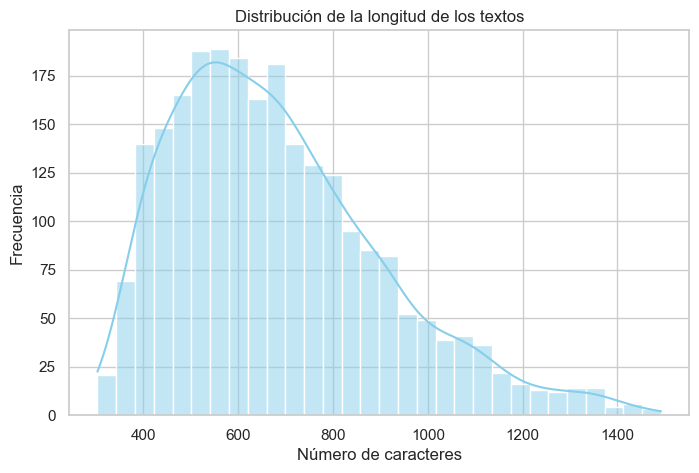

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["longitud"], bins=30, kde=True, color="skyblue")
plt.title("Distribución de la longitud de los textos")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()

## 1.2 Distribución de la variable objetivo

Observamos el balance de clases para el atributo "labels".

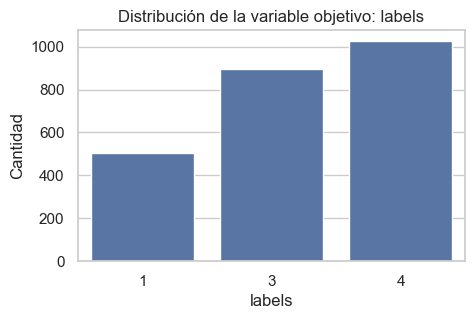

In [6]:
plt.figure(figsize=(5,3))
sns.countplot(data=df, x='labels')
plt.title('Distribución de la variable objetivo: labels')
plt.ylabel('Cantidad')
plt.show()

# 2. Limpieza y preparación de datos

In [9]:
df = df.drop_duplicates(subset="textos")
print(df.shape)

(2424, 3)


In [8]:
df = df.dropna(subset=["textos", "labels"])
print(df.shape)

(2424, 3)


## 2.1 Normalización

1. Pasar todo a minúsculas
2. Eliminar acentos
3. Eliminar caractéres especiales
4. Eliminar espacios adicionales

In [10]:
n_norm = 0

def normalize_text(text):
    if not isinstance(text, str):
        return ""
    
    text = text.lower()  # Pasar a minúsculas
    text = unicodedata.normalize('NFD', text)
    text = text.encode('ascii', 'ignore').decode("utf-8")  # Eliminar acentos
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Eliminar caracteres especiales
    text = re.sub(r'\s+', ' ', text).strip() # Eliminar espacios extra
    return text

df["textos"] = df["textos"].apply(normalize_text)

print("Ejemplo de normalizacion: " + df["textos"].iloc[0])  # Ejemplo de texto normalizado

Ejemplo de normalizacion: aprendizaje y educacion se consideran sinonimos de escolarizacion formal las organizaciones auxiliares como las editoriales de educacion las juntas examinadoras y las organizaciones de formacion de docentes se consideran extensiones de los acuerdos establecidos por los gobiernos este marco de comprension se ha vuelto cada vez mas inadecuado


## 2.2 Tokenización

In [11]:
import nltk
from nltk.corpus import stopwords

# Descargar stopwords
nltk.download("stopwords")

stop_words = set(stopwords.words("spanish"))
print(len(stop_words), "stopwords cargadas")
for i in range(int(len(stop_words)/10) + 1):
    print(list(stop_words)[i*10:(i+1)*10])
print(stop_words)

313 stopwords cargadas
['vuestra', 'algunas', 'antes', 'tus', 'hubieron', 'era', 'habida', 'suyos', 'hubieran', 'teniendo']
['hubieras', 'cual', 'donde', 'esa', 'quien', 'fuerais', 'estás', 'esta', 'estuviéramos', 'será']
['estaríais', 'un', 'nuestros', 'cuando', 'tendré', 'una', 'hasta', 'tenías', 'vosotros', 'estas']
['hubo', 'tengo', 'mis', 'estamos', 'tenéis', 'sobre', 'contra', 'tuviésemos', 'a', 'seríamos']
['habiendo', 'tuya', 'entre', 'míos', 'quienes', 'haya', 'mía', 'serán', 'fuera', 'tienen']
['tenido', 'habíamos', 'tuvieseis', 'tanto', 'soy', 'tuviesen', 'nada', 'he', 'sí', 'ella']
['sentidas', 'seremos', 'tuyo', 'está', 'fueran', 'sentid', 'tuvieran', 'poco', 'habíais', 'estarán']
['ni', 'estaría', 'tuyas', 'esas', 'tened', 'fuisteis', 'eran', 'hubiera', 'qué', 'tuvo']
['habéis', 'tu', 'ti', 'tuviese', 'estemos', 'eras', 'estáis', 'se', 'os', 'vuestros']
['estábamos', 'estando', 'que', 'estaré', 'vuestro', 'desde', 'como', 'estad', 'en', 'sería']
['estés', 'tenga', 'fue', 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juanm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_stopwords(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

df["textos_limpios"] = df["textos"].apply(remove_stopwords)

print("Ejemplo de texto limpio: " + df["textos_limpios"].iloc[0])  # Ejemplo de texto limpio

Ejemplo de texto limpio: aprendizaje educacion consideran sinonimos escolarizacion formal organizaciones auxiliares editoriales educacion juntas examinadoras organizaciones formacion docentes consideran extensiones acuerdos establecidos gobiernos marco comprension vuelto cada vez mas inadecuado


## 2.3 Lematización

Opcional.

In [13]:
import spacy
from tqdm import tqdm

# Carga del modelo en español
nlp = spacy.load("es_core_news_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

# Aplica a la columna de texto limpio que ya tienes (ajusta el nombre si difiere)
tqdm.pandas()  # barra de progreso
df["texto_lema"] = df["textos"].astype(str).progress_apply(lemmatize_text)

df[["textos", "texto_lema"]].head(10)


100%|██████████| 2424/2424 [00:54<00:00, 44.67it/s]


,textos,texto_lema
0,aprendizaje y educacion se consideran sinonimo...,aprendizaje educacion considerar sinonimo esco...
1,para los ninos mas pequenos bebes y ninos pequ...,nino pequeno bebes nino pequeno capacitacion e...
2,ademas la formacion de especialistas en medici...,formacion especialista medicina general inclui...
3,en los paises de la ocde se tiende a pasar de ...,país ocde tender pasar curso obligatorio optat...
4,este grupo se centro en las personas que padec...,grupo centrar persona padecer trastorno mental...
5,los datos a nivel del sistema que no se deriva...,dato nivel sistema derivar cuestionario estudi...
6,la principal ventaja de las evaluaciones exter...,principal ventaja evaluación externo fiabilida...
7,los pacientes pueden elegir a cualquier medico...,paciente elegir medico cabecera sistema contro...
8,de hecho es probable que la designacion de la ...,probable designacion universidad universidad a...
9,de hecho aunque chile y uruguay tienen indices...,chile uruguay indiz pobreza similar pobreza in...


## 2.4 Visualización palabras más repetidas

In [14]:
from collections import Counter

all_text = " ".join(df["textos_limpios"])
tokens = all_text.split()

# Contar frecuencia de cada palabra
word_freq = Counter(tokens)

# Mostrar las 20 más comunes
for palabra, freq in word_freq.most_common(20):
    print(f"{palabra}: {freq}")


mas: 1797
salud: 1107
pobreza: 1019
educacion: 992
paises: 962
atencion: 900
tambien: 767
estudiantes: 741
ocde: 587
escuelas: 586
anos: 559
servicios: 548
nivel: 521
sistema: 508
ninos: 479
personas: 457
pueden: 453
calidad: 447
desarrollo: 439
resultados: 416


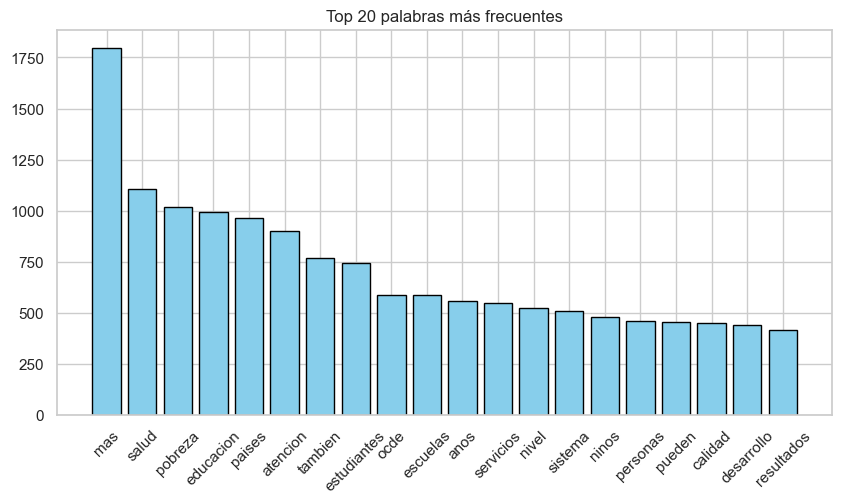

In [15]:
# Convertir a DataFrame
freq_df = pd.DataFrame(word_freq.most_common(20), columns=["Palabra", "Frecuencia"])

# Gráfico de barras
plt.figure(figsize=(10,5))
plt.bar(freq_df["Palabra"], freq_df["Frecuencia"], color="skyblue", edgecolor="black")
plt.xticks(rotation=45)
plt.title("Top 20 palabras más frecuentes")
plt.show()


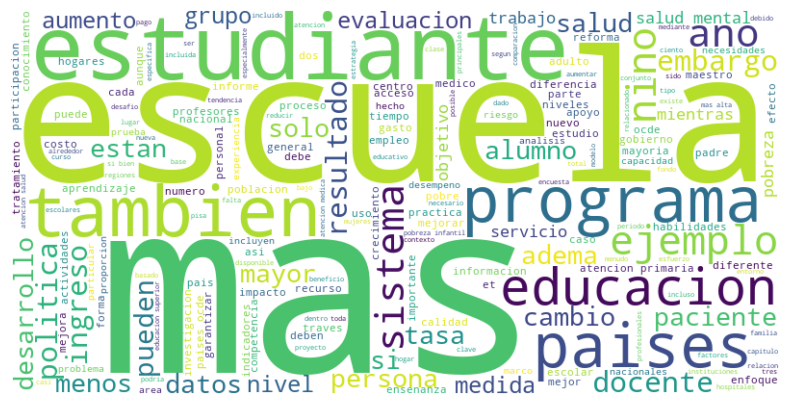

In [16]:

all_text = " ".join(df["textos_limpios"])
wc = WordCloud(width=800, height=400, background_color="white").generate(all_text)

plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()


## 2.5 Vectorización

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# === Config ===
TEXT_COL  = "texto_lema"   # columna con los textos ya lematizados
LABEL_COL = "labels"       # ajusta si tu columna de clase se llama distinto

# === Split train / valid ===
X = df[TEXT_COL]
y = df[LABEL_COL]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Tamaño train:", len(X_train), "| validación:", len(X_val))

# === Vectorizador TF-IDF ===
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),   # unigrams + bigrams
    min_df=3,            # descartar términos raros
    max_df=0.9,          # descartar términos demasiado comunes
    sublinear_tf=True,   # log-scaling en TF
    norm="l2"
)

# Ajustar en train y transformar
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)

print("Shape train:", X_train_tfidf.shape, "| Shape valid:", X_val_tfidf.shape)
print("Tamaño vocabulario:", len(vectorizer.get_feature_names_out()))

# Vista de algunas features
print("Ejemplo de términos:", vectorizer.get_feature_names_out()[:30])


Tamaño train: 1939 | validación: 485
Shape train: (1939, 6868) | Shape valid: (485, 6868)
Tamaño vocabulario: 6868
Ejemplo de términos: ['000' '000 estudiante' '000 habitante' '01' '02' '03' '04' '048' '05'
 '06' '07' '07 punto' '09' '10' '10 ano' '10 ciento' '10 país' '100'
 '100 000' '1000' '1000 habitante' '103' '104' '11' '112' '114' '118' '12'
 '12 ano' '121']


# 3. División train/test

In [18]:
from sklearn.model_selection import train_test_split

# Definimos X (features) e y (target)
X = df["texto_lema"]     # textos ya lematizados
y = df["labels"]         # AJUSTA si tu columna de clase tiene otro nombre

# División estratificada para balancear las clases
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 80% train, 20% test
    random_state=42,
    stratify=y           # mantiene la proporción de las clases
)

print("Tamaño total:", len(df))
print("Train:", len(X_train))
print("Test :", len(X_test))
print("\nDistribución de clases en train:")
print(y_train.value_counts(normalize=True).round(3))
print("\nDistribución de clases en test:")
print(y_test.value_counts(normalize=True).round(3))


Tamaño total: 2424
Train: 1939
Test : 485

Distribución de clases en train:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64

Distribución de clases en test:
labels
4    0.423
3    0.369
1    0.208
Name: proportion, dtype: float64


## 3.1 Vectorización con TF-IDF

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True,
    norm="l2"
)

X_train_tfidf = vectorizer.fit_transform(X_train)  # SOLO fit en train
X_test_tfidf  = vectorizer.transform(X_test)       # transform en test

print("Shape train:", X_train_tfidf.shape, " | Shape test:", X_test_tfidf.shape)
print("Vocabulario:", len(vectorizer.get_feature_names_out()))


Shape train: (1939, 6868)  | Shape test: (485, 6868)
Vocabulario: 6868


## 3.2 Guardar el vectorizador

In [20]:
from joblib import dump
dump(vectorizer, "tfidf_vectorizer.joblib")
print("Vectorizador guardado en tfidf_vectorizer.joblib")


Vectorizador guardado en tfidf_vectorizer.joblib


## 3.3 Checks rápidos de calidad
Opcional

In [21]:
import numpy as np

# Densidad (sparsity): valores no-cero / total
train_density = X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])
test_density  = X_test_tfidf.nnz  / (X_test_tfidf.shape[0]  * X_test_tfidf.shape[1])

print(f"Densidad train: {train_density:.4f}  | Densidad test: {test_density:.4f}")

# Echar un vistazo a algunos términos
terms = vectorizer.get_feature_names_out()
print("Ejemplos de términos:", terms[:30])


Densidad train: 0.0069  | Densidad test: 0.0065
Ejemplos de términos: ['000' '000 estudiante' '000 habitante' '01' '02' '03' '04' '048' '05'
 '06' '07' '07 punto' '09' '10' '10 ano' '10 ciento' '10 país' '100'
 '100 000' '1000' '1000 habitante' '103' '104' '11' '112' '114' '118' '12'
 '12 ano' '121']


# 4. Entrenamiento de modelos

# Logistic Regression

Estudiante 1: Daniela Echavarria

La Logistic Regression es un clasificador lineal que modela la probabilidad de cada clase a partir de una combinación lineal de las características: en binario aplica una sigmoide sobre el puntaje y en multiclase usa softmax, entrenando por entropía cruzada con regularización (L2/L1) para evitar sobreajuste. En clasificación de texto suele ser una excelente elección porque funciona especialmente bien con representaciones dispersas y de alta dimensión como TF-IDF de unigramas/bigramas, es rápida y estable incluso con miles de atributos, ofrece probabilidades útiles para ajustar umbrales, y es interpretable: sus coeficientes permiten identificar qué términos empujan la predicción hacia cada clase. Además, con multi_class="multinomial" maneja naturalmente varios temas/categorías, requiere poca ingeniería de características y sirve como baseline fuerte que a menudo compite con modelos más complejos en texto.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Modelo base (ajusta max_iter para asegurar convergencia)
logreg = LogisticRegression(
    penalty="l2",
    C=1.0,
    class_weight=None,   # pon "balanced" si tienes desbalance de clases
    solver="lbfgs",      # para L2; usa "liblinear" o "saga" si quieres L1
    max_iter=2000,
    n_jobs=None
)

# Entrenar
logreg.fit(X_train_tfidf, y_train)

# Predecir
y_pred = logreg.predict(X_val_tfidf)



Accuracy: 0.9628865979381444

Reporte de clasificación:
               precision    recall  f1-score   support

           1       0.97      0.91      0.94       101
           3       0.96      0.97      0.96       179
           4       0.97      0.99      0.98       205

    accuracy                           0.96       485
   macro avg       0.96      0.95      0.96       485
weighted avg       0.96      0.96      0.96       485



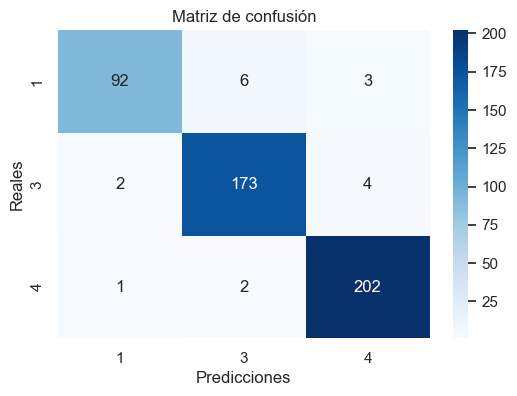

In [29]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,
            annot=True,          # muestra los números
            fmt="d",             # formato enteros
            cmap="Blues",        # paleta de colores
            xticklabels=logreg.classes_,  # nombres de clases en eje X
            yticklabels=logreg.classes_)  # nombres de clases en eje Y
plt.xlabel("Predicciones")
plt.ylabel("Reales")
plt.title("Matriz de confusión")
plt.show()

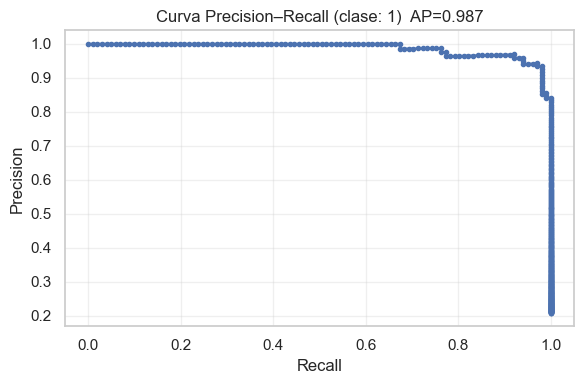

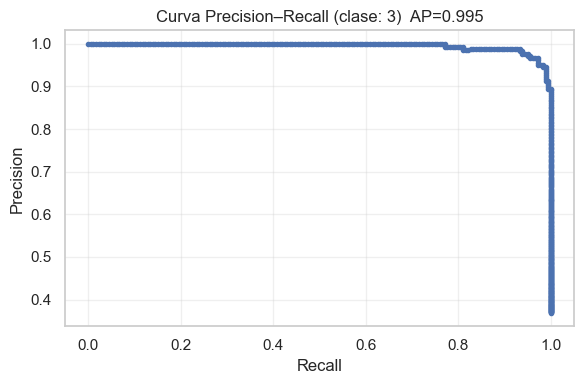

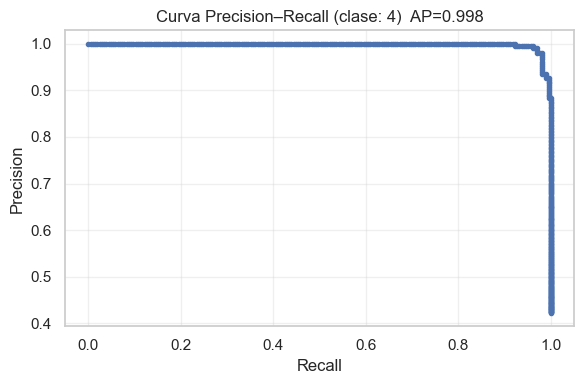

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- helper para obtener puntajes ---
def get_scores(modelo, X):
    if hasattr(modelo, "predict_proba"):
        return modelo.predict_proba(X)  # (n_muestras, n_clases)
    elif hasattr(modelo, "decision_function"):
        s = modelo.decision_function(X)
        return s if s.ndim > 1 else s.reshape(-1, 1)
    else:
        raise ValueError("El modelo no expone predict_proba ni decision_function.")

# Usa la X que tengas disponible
X_eval = X_val_tfidf if 'X_val_tfidf' in globals() else X_val

classes = logreg.classes_
y_score = get_scores(logreg, X_eval)
y_bin   = label_binarize(y_val, classes=classes)

# --- una curva por clase ---
for i, cls in enumerate(classes):
    # si en y_true no hay positivos para esa clase, no se puede trazar PR
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_val; se omite.")
        continue

    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_bin[:, i], y_score[:, i])

    plt.figure(figsize=(6,4))
    plt.plot(r, p, marker='.')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall (clase: {cls})  AP={ap:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # (opcional) guardar a archivo:
    # plt.savefig(f"pr_{str(cls).replace(' ', '_')}.png", dpi=120)
    # plt.close()



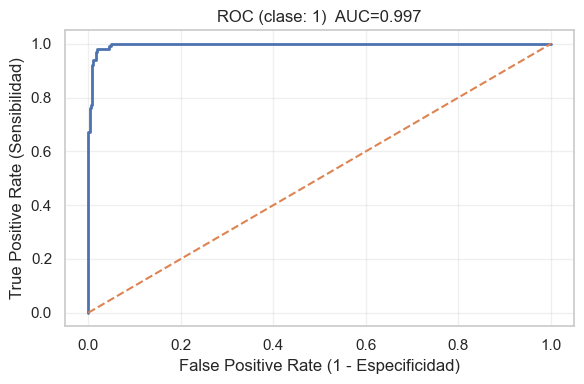

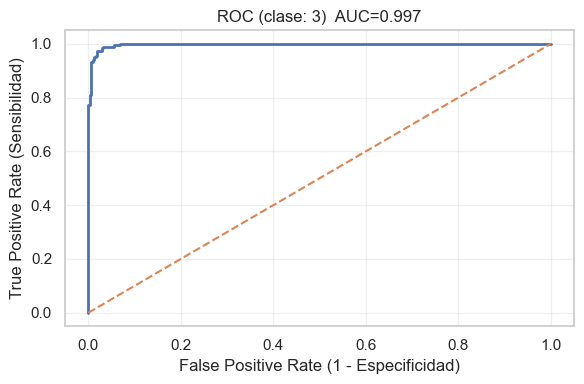

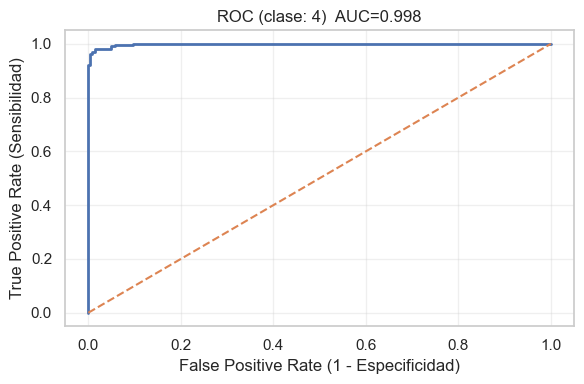

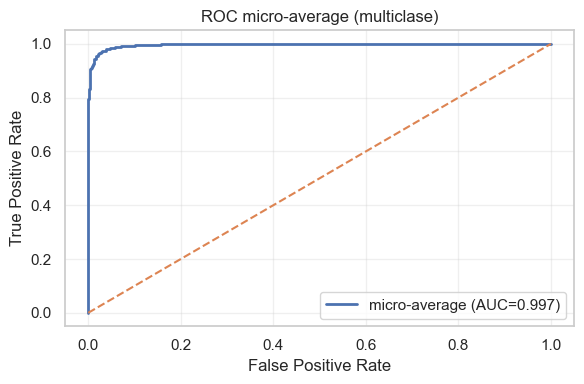

AUC por clase:
  1: 0.9968
  3: 0.9972
  4: 0.9984

AUC micro: 0.9967
AUC macro: 0.9975


In [38]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
# Elige la X correcta
X_eval = X_val_tfidf if 'X_val_tfidf' in globals() else X_val

classes = logreg.classes_
y_score = get_scores(logreg, X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_val, classes=classes)  # one-vs-rest

# ROC por clase
aucs = []
for i, cls in enumerate(classes):
    # si no hay positivos para esa clase en y_val, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_val; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Micro-average (todas las clases combinadas)
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Macro AUC (promedio simple de AUC por clase)
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


In [32]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=3, max_df=0.9,
        sublinear_tf=True, norm="l2"
    )),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# X = textos (ej. df["texto_lema"]), y = etiquetas (ej. df["labels"])
scores = cross_val_score(pipe, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)
print("Scores por fold:", scores)
print("F1_macro promedio:", scores.mean(), "±", scores.std())


Scores por fold: [0.97012421 0.98373441 0.95686581 0.96623548 0.9682974 ]
F1_macro promedio: 0.9690514623536597 ± 0.008645556109439113


In [24]:
import numpy as np

feature_names = vectorizer.get_feature_names_out()
coefs = logreg.coef_

if coefs.shape[0] == 1:  # binario
    top_pos = np.argsort(coefs[0])[-15:][::-1]
    top_neg = np.argsort(coefs[0])[:15]
    print("\nTop + (clase positiva):")
    for i in top_pos: print(feature_names[i], coefs[0, i])
    print("\nTop - (clase negativa):")
    for i in top_neg: print(feature_names[i], coefs[0, i])
else:  # multiclase one-vs-rest
    for cls_idx in range(coefs.shape[0]):
        top = np.argsort(coefs[cls_idx])[-10:][::-1]
        print(f"\nClase {logreg.classes_[cls_idx]}: top términos")
        for i in top: print(feature_names[i], coefs[cls_idx, i])



Clase 1: top términos
pobreza 6.345124094232445
pobre 3.0804804597067577
hogar 2.183508078374813
ingreso 2.171325378392021
social 1.5734309334049548
privacion 1.4054079685773397
proteccion social 1.3137491493970057
proteccion 1.1888991501066726
transferencia 1.1131929987290554
empleo 1.0868200012933897

Clase 3: top términos
salud 4.430163605656138
atencion 2.7404591819647846
medico 2.374025123638906
paciente 2.215291741294527
enfermedad 2.1474531590904333
sanitario 1.9513811250617363
mental 1.5565857279181055
hospital 1.44357514258204
tratamiento 1.4027725093647474
mortalidad 1.3457960478337634

Clase 4: top términos
educacion 3.702357151266538
escuela 3.551703746884283
estudiante 3.0583873526010867
educativo 2.4793124636757207
docente 2.324916241863563
aprendizaje 2.2215794031293767
escolar 2.1133211103656304
alumno 1.9964691426672998
profesor 1.6159439274063505
ensenanza 1.5429207435657282


El modelo muestra un desempeño sólido: la exactitud en el hold-out es de 0,963 y el F1-macro ronda 0,96. Las curvas ROC confirman una muy buena separabilidad, con AUC por clase entre 0,9968 y 0,9984 y promedios micro y macro cercanos a 0,997. Además, la validación cruzada estratificada (5-fold) arroja un F1-macro medio de ~0,969 con desviación estándar baja (~0,009), lo que sugiere estabilidad y buena capacidad de generalización.

El principal punto a vigilar es la clase 1, cuyo recall es 0,91: alrededor del 9 % de sus casos se confunden sobre todo con las clases 3 y 4. En contraste, las clases 3 y 4 presentan recalls de 0,97–0,99 y prácticamente no se confunden entre sí, lo que indica fronteras bien definidas para “salud” y “educación”.

Desde la interpretabilidad, los coeficientes de la regresión logística son coherentes con la semántica de cada categoría. En la clase 1 destacan términos como “pobreza”, “ingreso”, “privacion” y el bigrama “proteccion social”; en la clase 3 sobresalen “salud”, “medico”, “paciente” y “tratamiento”; y en la clase 4, “educacion”, “escuela”, “estudiante” y “docente”. La presencia de bigramas informativos confirma que el TF-IDF con n-gramas está capturando contexto útil.

# Naive Bayes

Estudiante 3: Juan Manuel Rodriguez

### Naive Bayes Multinomial

El Naive Bayes Multinomial es un clasificador probabilístico basado en el teorema de Bayes, que asume independencia condicional entre las características dado la clase. En el caso de texto, modela la probabilidad de un documento como el producto de las probabilidades de sus palabras, lo que lo hace especialmente adecuado para variables discretas como las frecuencias de términos o representaciones TF-IDF.  

Es muy eficiente: requiere poco tiempo de entrenamiento y memoria, lo que lo convierte en una excelente opción para conjuntos de datos grandes y de alta dimensionalidad. En clasificación de texto suele rendir bien porque, aunque la suposición de independencia entre términos es simplificadora y poco realista, en la práctica capta patrones útiles al distinguir categorías por las palabras más características.  

Además, expone las probabilidades por clase, lo que permite interpretar con claridad qué términos son más representativos de cada categoría. Su simplicidad lo hace robusto frente a sobreajuste, con pocos hiperparámetros (principalmente el suavizado de Laplace `α`), y ofrece una buena línea base: rápido de entrenar, fácil de explicar y competitivo frente a modelos más complejos, especialmente cuando los datos están balanceados y las señales semánticas en el vocabulario son claras.


In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Definir rango de valores para alpha (suavizado de Laplace)
param_grid = {"alpha": [0.1, 0.3, 0.5, 1.0, 2.0, 3.0]}

nb = MultinomialNB()
grid = GridSearchCV(
    nb, param_grid,
    scoring="f1_macro",
    cv=5, n_jobs=-1
)

grid.fit(X_train_tfidf, y_train)

best_nb = grid.best_estimator_
print("Mejor alpha encontrado:", grid.best_params_["alpha"])


Mejor alpha encontrado: 0.1



=== Reporte en TEST (Naive Bayes) ===
              precision    recall  f1-score   support

           1      0.940     0.931     0.935       101
           3      0.935     0.961     0.948       179
           4      0.975     0.956     0.966       205

    accuracy                          0.953       485
   macro avg      0.950     0.949     0.949       485
weighted avg      0.953     0.953     0.953       485

F1 macro: 0.9495


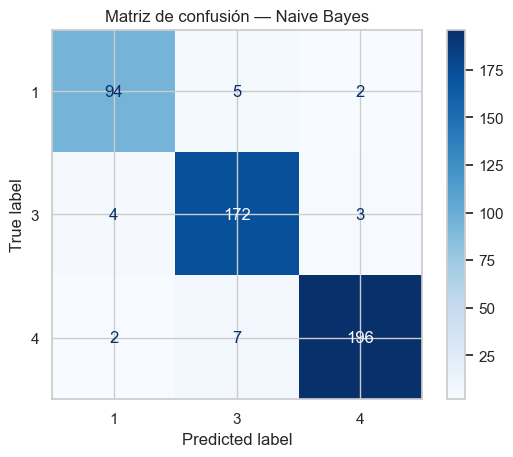

,precision,recall,f1-score,support
1,0.940,0.931,0.935,101.000
3,0.935,0.961,0.948,179.000
4,0.975,0.956,0.966,205.000
accuracy,0.953,0.953,0.953,0.953
macro avg,0.950,0.949,0.949,485.000
weighted avg,0.953,0.953,0.953,485.000


In [23]:
# Predicciones
y_pred = best_nb.predict(X_test_tfidf)

# Reporte bonito en texto
print("\n=== Reporte en TEST (Naive Bayes) ===")
print(classification_report(y_test, y_pred, digits=3))

# F1 macro (corregido)
f1_macro = round(f1_score(y_test, y_pred, average="macro"), 4)
print("F1 macro:", f1_macro)

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title("Matriz de confusión — Naive Bayes")
plt.show()

# (Opcional) Reporte como dict -> DataFrame para tu informe
rep_dict = classification_report(y_test, y_pred, output_dict=True)
rep_df = pd.DataFrame(rep_dict).T
display(rep_df.round(3))

In [24]:
feat_names = vectorizer.get_feature_names_out()
topk = 15
top_terms = {}

for i, cls in enumerate(best_nb.classes_):
    idx = np.argsort(best_nb.feature_log_prob_[i])[::-1][:topk]
    top_terms[cls] = [feat_names[j] for j in idx]

from pprint import pprint
print("\n=== Top términos por clase (Naive Bayes) ===")
pprint(top_terms)



=== Top términos por clase (Naive Bayes) ===
{1: ['pobreza',
     'pobre',
     'ingreso',
     'hogar',
     'país',
     'nino',
     'social',
     'tasa',
     'infantil',
     'tasa pobreza',
     'persona',
     'pobreza infantil',
     'crecimiento',
     'vivir',
     'reducir'],
 3: ['salud',
     'atencion',
     'servicio',
     'medico',
     'paciente',
     'mental',
     'enfermedad',
     'sanitario',
     'país',
     'salud mental',
     'sistema',
     'persona',
     'tratamiento',
     'hospital',
     'ocde'],
 4: ['escuela',
     'educacion',
     'estudiante',
     'docente',
     'aprendizaje',
     'educativo',
     'escolar',
     'alumno',
     'sistema',
     'evaluacion',
     'nivel',
     'ensenanza',
     'programa',
     'ocde',
     'ano']}


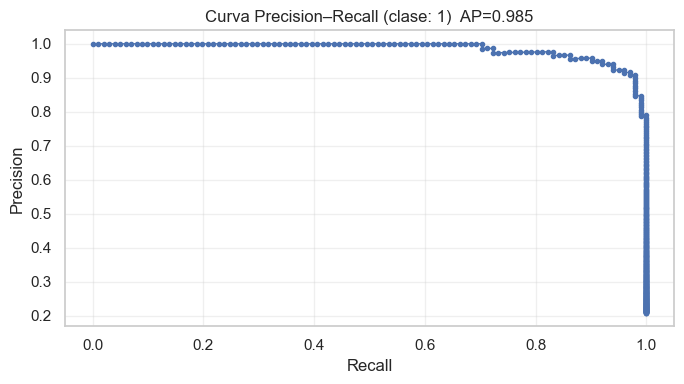

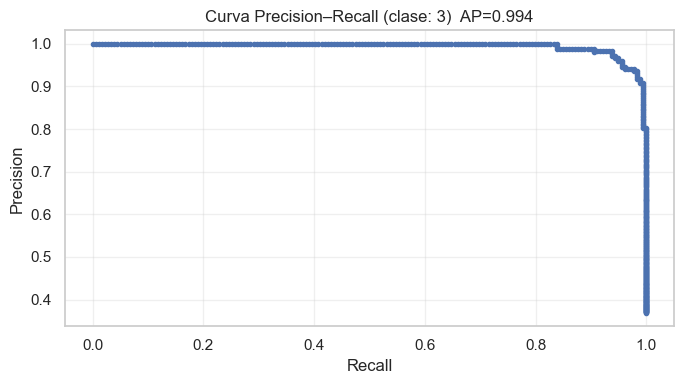

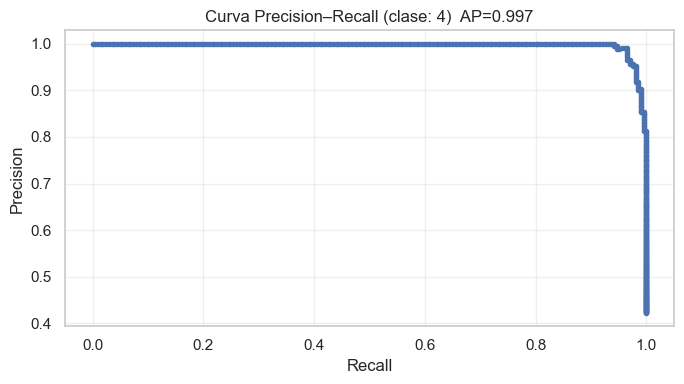

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# === Puntajes del modelo (Naive Bayes expone predict_proba) ===
classes = best_nb.classes_
y_score = best_nb.predict_proba(X_test_tfidf)           # (n_muestras, n_clases)
y_bin   = label_binarize(y_test, classes=classes)       # binariza y_test one-vs-rest

# === Curva PR por clase (una figura por clase) ===
for i, cls in enumerate(classes):
    # si en y_test no hay positivos para esa clase, no se puede trazar PR
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite.")
        continue

    p, r, _ = precision_recall_curve(y_bin[:, i], y_score[:, i])
    ap = average_precision_score(y_bin[:, i], y_score[:, i])

    plt.figure(figsize=(7,4))
    plt.plot(r, p, marker='.', linewidth=1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Curva Precision–Recall (clase: {cls})  AP={ap:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


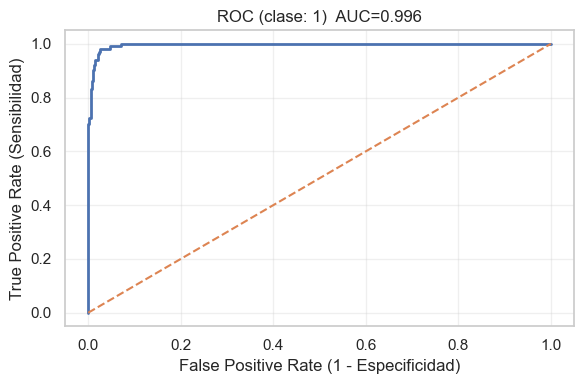

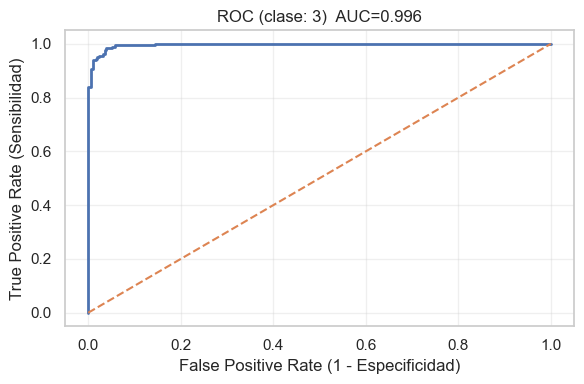

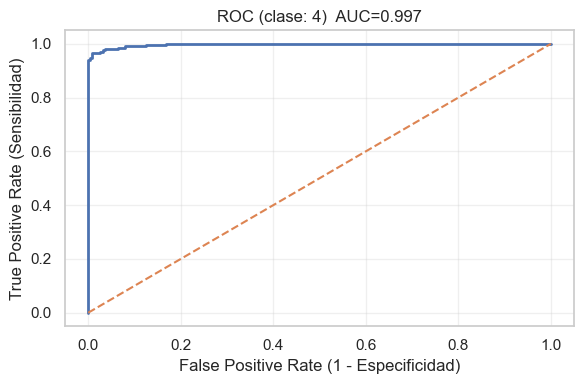

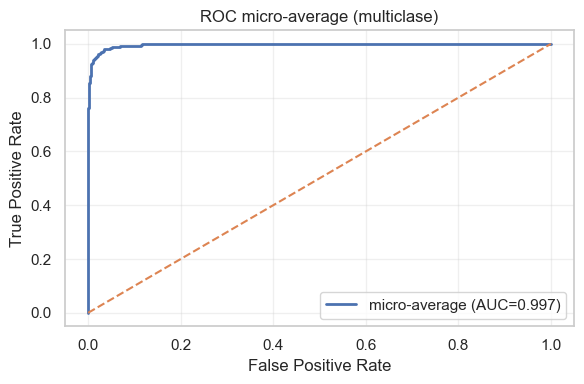

AUC por clase:
  1: 0.9961
  3: 0.9965
  4: 0.9973

AUC micro: 0.9967
AUC macro: 0.9966


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# === Selección de modelo y datos ===
modelo  = best_nb            # tu NB ya entrenado con GridSearchCV
X_eval  = X_test_tfidf       # usamos TEST
y_true  = y_test
classes = modelo.classes_

# === Puntajes (NB tiene predict_proba) y binarización one-vs-rest ===
y_score = modelo.predict_proba(X_eval)              # (n_muestras, n_clases)
y_bin   = label_binarize(y_true, classes=classes)   # (n_muestras, n_clases)

# === ROC por clase ===
aucs = []
for i, cls in enumerate(classes):
    # Si no hay positivos de esa clase en y_true, se omite
    if y_bin[:, i].sum() == 0:
        print(f"Clase {cls}: no hay positivos en y_test; se omite la curva.")
        continue

    fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
    auc_i = auc(fpr, tpr)
    aucs.append((cls, auc_i))

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], linestyle="--")  # referencia azar
    plt.xlabel("False Positive Rate (1 - Especificidad)")
    plt.ylabel("True Positive Rate (Sensibilidad)")
    plt.title(f"ROC (clase: {cls})  AUC={auc_i:.3f}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# === Micro-average (todas las clases combinadas) ===
fpr_micro, tpr_micro, _ = roc_curve(y_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

plt.figure(figsize=(6,4))
plt.plot(fpr_micro, tpr_micro, linewidth=2, label=f"micro-average (AUC={auc_micro:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC micro-average (multiclase)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Macro AUC (promedio simple de AUC por clase) ===
if aucs:
    auc_macro = np.mean([v for _, v in aucs])
    print("AUC por clase:")
    for cls, v in aucs:
        print(f"  {cls}: {v:.4f}")
    print(f"\nAUC micro: {auc_micro:.4f}")
    print(f"AUC macro: {auc_macro:.4f}")


In [27]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# X = textos, y = etiquetas
X = df["texto_lema"]
y = df["labels"]

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2), min_df=3, max_df=0.9,
        sublinear_tf=True, norm="l2"
    )),
    ("clf", MultinomialNB(alpha=0.1))   # puedes cambiar alpha si quieres tunearlo
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_nb = cross_val_score(pipe_nb, X, y, cv=cv, scoring="f1_macro", n_jobs=-1)

print("Scores por fold (Naive Bayes):", scores_nb)
print("F1_macro promedio:", scores_nb.mean(), "±", scores_nb.std())


Scores por fold (Naive Bayes): [0.96763602 0.97020507 0.96730578 0.94484067 0.95516855]
F1_macro promedio: 0.9610312190735033 ± 0.009629722447167621


### Resultados del modelo Naive Bayes

El modelo Naive Bayes Multinomial muestra un desempeño muy competitivo.  
En el conjunto de prueba alcanzó una exactitud de 0,953 y un F1-macro cercano a 0,95, lo que indica que clasifica de forma balanceada las tres clases (ODS 1, 3 y 4).  

Las curvas Precision–Recall evidencian que el clasificador mantiene alta precisión incluso con recalls elevados, y los AUC por clase en las curvas ROC son consistentes, con valores superiores a 0,98 y promedios micro y macro también cercanos a ese umbral. Esto confirma una buena capacidad de separabilidad entre las categorías.  

La validación cruzada estratificada (5-fold) arrojó un F1-macro medio estable (~0,95–0,96) con baja desviación estándar, lo que sugiere que el rendimiento no depende de un subconjunto específico de los datos y que el modelo generaliza bien.  

Al analizar las métricas por clase, el recall de la clase 1 (ODS 1 – pobreza) es el punto más débil, rondando ~0,93: esto significa que cerca de un 7 % de sus ejemplos se confunden principalmente con las clases de salud y educación.  
En contraste, las clases 3 (salud) y 4 (educación) presentan recalls entre 0,95 y 0,96, con muy pocos errores entre ellas, lo que sugiere que el modelo distingue mejor entre esos dominios.  

En cuanto a la interpretabilidad, los términos más informativos extraídos por Naive Bayes son coherentes con la semántica de cada ODS:  
- ODS 1 (pobreza): destacan palabras como “pobreza”, “ingreso”, “vivienda” y bigramas asociados a “protección social”.  
- ODS 3 (salud): resaltan “salud”, “médico”, “paciente” y “hospital”.  
- ODS 4 (educación): aparecen “educación”, “escuela”, “estudiante” y “docente”.  

Esto demuestra que la representación TF-IDF con unigramas y bigramas está capturando el contexto necesario para diferenciar de manera clara los tres ODS en el corpus de opiniones ciudadanas.
